In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [3]:
data = pd.read_csv('../data/eagles.csv')

data = data.assign(
    pirate_large = (data.P == 'L').astype('int'),
    pirate_adult = (data.A == 'A').astype('int'),
    victim_large = (data.V == 'L').astype('int'),
    ratio = data.y / data.n
)

data

,y,n,P,A,V,pirate_large,pirate_adult,victim_large,ratio
0,17,24,L,A,L,1,1,1,0.708333
1,29,29,L,A,S,1,1,0,1.000000
2,17,27,L,I,L,1,0,1,0.629630
3,20,20,L,I,S,1,0,0,1.000000
4,1,12,S,A,L,0,1,1,0.083333
5,15,16,S,A,S,0,1,0,0.937500
6,0,28,S,I,L,0,0,1,0.000000
7,1,4,S,I,S,0,0,0,0.250000


**H3** The data contained in `library(MASS);data(eagles)` are records of salmon pirating attempts by Bald Eagles in Washington State. While one eagle feeds, sometimes another will swoop in and try to steal the salmon from it. Call the feeding eagle the “victim” and the thief the “pirate.” Use the available data to build a binomial GLM of successful pirating attempts.

(a) Consider the following model:

```
yi ∼ Binomial(ni , pi)
pi
log(pi/(1-pi) = α + βP Pi + βV Vi + βA Ai
α ∼ Normal(0, 10)
βP ∼ Normal(0, 5)
βV ∼ Normal(0, 5)
βA ∼ Normal(0, 5)
```

where `y` is the number of successful attempts, `n` is the total number of attempts, `P` is a dummy variable indicating whether or not the pirate had large body size, `V` is a dummy variable indicating whether or not the victim had large body size, and finally `A` is a dummy variable indicating whether or not the pirate was an adult. Fit the model above to the eagles data, using both `map` and `map2stan`. Is the quadratic approximation okay?


In [4]:
with pm.Model() as model_h3_a:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_p = pm.Normal('beta_p', mu=0, sd=5)
    beta_v = pm.Normal('beta_v', mu=0, sd=5)
    beta_a = pm.Normal('beta_a', mu=0, sd=5)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            alpha
            + beta_p * data.pirate_large
            + beta_v * data.victim_large
            + beta_a * data.pirate_adult
        )
    )

    y = pm.Binomial('y', p=p, n=data.n, observed=data.y)

    model_h3_a.name = 'h3.a'
    model_h3_a.map_ = pm.find_MAP()
    model_h3_a.trace = pm.sample(3000, tune=500, chains=2)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -21.517, ||grad|| = 0.025703: 100%|██████████| 17/17 [00:00<00:00, 1027.65it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_a, beta_v, beta_p, alpha]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:12<00:00, 564.54draws/s]


In [5]:
model_h3_ael_h3_a.map_

{'alpha': array(0.59154318),
 'beta_p': array(4.24182384),
 'beta_v': array(-4.59260843),
 'beta_a': array(1.08141052),
 'p': array([0.78954236, 0.99730801, 0.55990058, 0.99210318, 0.05119047,
        0.84196923, 0.0179674 , 0.64371914])}

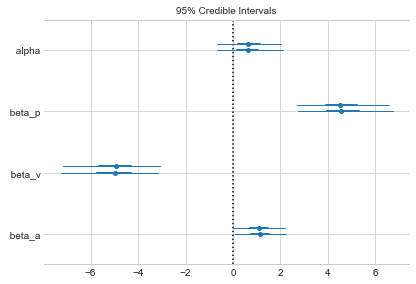

In [6]:
pm.forestplot(model_h3_a.trace, varnames=['alpha', 'beta_p', 'beta_v', 'beta_a'], rhat=False)
None

(b) Now interpret the estimates. If the quadratic approximation turned out okay, then it’s okay to use the map estimates. Otherwise stick to map2stan estimates. Then plot the posterior predictions. Compute and display both (1) the predicted probability of success and its 89% interval for each row (i) in the data, as well as (2) the predicted success count and its 89% interval. What different information does each type of posterior prediction provide?



In [18]:
with model_h3_a:
    model_h3_a.ppc = pm.sample_posterior_predictive(
        model_h3_a.trace, vars=[y], samples=3000)

100%|██████████| 3000/3000 [00:01<00:00, 1596.60it/s]


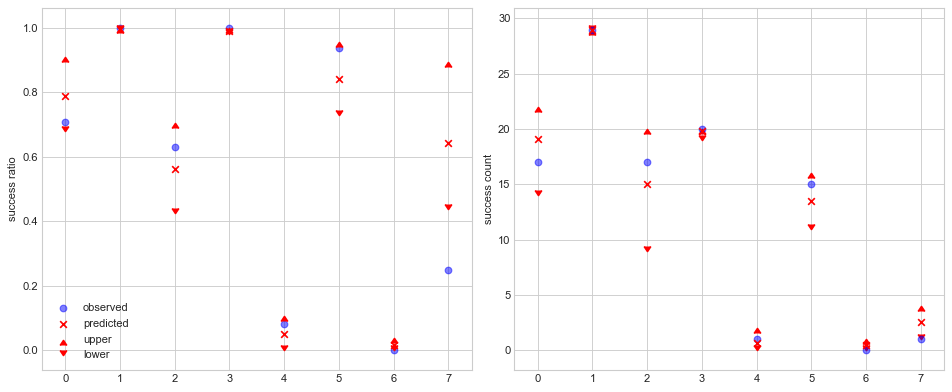

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=80)

tmp = agg_prediction(model_h3_a.trace['p'], data.reset_index(), ['index'], summarize(.11))

ax1.scatter(data.index, data.ratio, marker='o', color='b', alpha=.5, label='observed')
ax1.scatter(tmp['index'], tmp.mean_, marker='x', color='r', label='predicted')
ax1.scatter(tmp['index'], tmp.upper, marker=6, color='r')
ax1.scatter(tmp['index'], tmp.lower, marker=7, color='r')
ax1.set(ylabel='success ratio')
ax1.legend()

tmp = agg_prediction(model_h3_a.ppc['y'], data.reset_index(), ['index'], summarize(.11))

ax2.scatter(tmp['index'], tmp.upper, marker=6, color='r')
ax2.scatter(tmp['index'], tmp.lower, marker=7, color='r')
ax2.scatter(data.index, data.y, marker='o', color='b', alpha=.5)
ax2.scatter(tmp['index'], tmp.mean_, marker='x', color='r')
ax2.set(ylabel='success count')

fig.tight_layout()
None

(c) Now try to improve the model. Consider an interaction between the pirate’s size and age (immature or adult). Compare this model to the previous one, using WAIC. Interpret.

In [13]:
with pm.Model() as model_h3_c:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_p = pm.Normal('beta_p', mu=0, sd=5)
    beta_v = pm.Normal('beta_v', mu=0, sd=5)
    beta_a = pm.Normal('beta_a', mu=0, sd=5)
    beta_pa = pm.Normal('beta_pa', mu=0, sd=5)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            alpha
            + beta_p * data.pirate_large.values
            + beta_v * data.victim_large.values
            + beta_a * data.pirate_adult.values
            + beta_pa * (data.pirate_large.values * data.pirate_adult.values)
        )
    )

    y = pm.Binomial('y', p=p, n=data.n, observed=data.y)

    model_h3_c.name = 'h3.c'
    model_h3_c.trace = pm.sample(3000, tune=5000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_pa, beta_a, beta_v, beta_p, alpha]
Sampling 2 chains: 100%|██████████| 16000/16000 [00:42<00:00, 377.45draws/s]


In [29]:
comparison = pm.compare({
        model_h3_a: model_h3_a.trace,
        model_h3_c: model_h3_c.trace,
    },
    method='BB-pseudo-BMA'
)

comparison

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
h3.c,20.86,2.13,0,0.98,5.31,0,1
h3.a,30.83,5.25,9.98,0.02,7.36,3.23,1


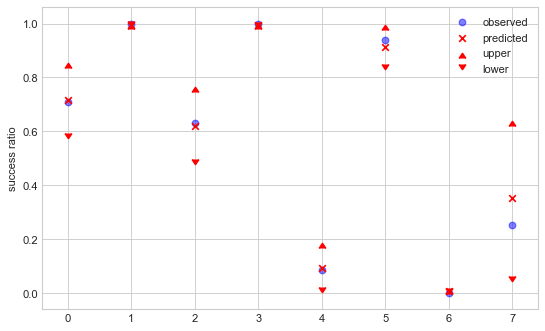

In [35]:
tmp = agg_prediction(model_h3_c.trace['p'], data.reset_index(), ['index'], summarize(.11))

fig, ax1= plt.subplots(1, 1, figsize=(8, 5), dpi=80)

ax1.scatter(data.index, data.ratio, marker='o', color='b', alpha=.5, label='observed')
ax1.scatter(tmp['index'], tmp.mean_, marker='x', color='r', label='predicted')
ax1.scatter(tmp['index'], tmp.upper, marker=6, color='r')
ax1.scatter(tmp['index'], tmp.lower, marker=7, color='r')
ax1.set(ylabel='success ratio')
ax1.legend()

None

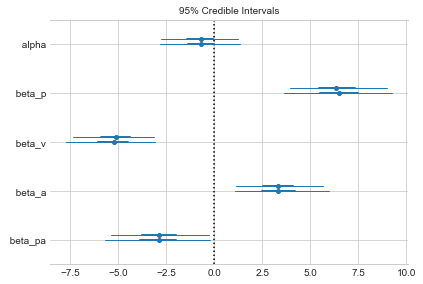

In [36]:
pm.forestplot(model_h3_c.trace, varnames=['alpha', 'beta_p', 'beta_v', 'beta_a', 'beta_pa'], rhat=False)
None